In [57]:
#this code is inspired by https://github.com/kimiandj/gsw/blob/master/code/GSW_flows_comparison.ipynb
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import optim
import ot
import pandas as pd
from tqdm import tqdm
from IPython import display
import time
import timeit
import matplotlib.pyplot as pl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
import os
import gradient_flows

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


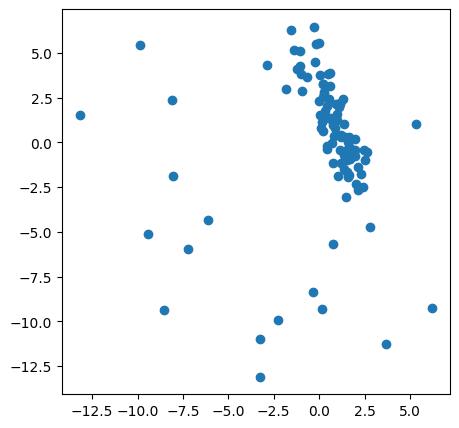

In [181]:
%load_ext autoreload
%autoreload 2
dataset_name = 'gaussian_2d_with_noise'
seed=0

np.random.seed(seed)
N = 100  # Number of samples from p_X
X = gradient_flows.load_data(name=dataset_name, n_samples=N,dim=2)
X -= X.mean(dim=0)[np.newaxis,:]  
#X-=torch.tensor([5,5])
meanX = 0

# plot the dataset
_, d = X.shape
fig = pl.figure(figsize=(5,5))
pl.scatter(X[:,0], X[:,1])
pl.show()

In [182]:
results_folder = './Results/Gradient_Flow'
if not os.path.isdir(results_folder):
    os.mkdir(results_folder)
foldername = os.path.join(results_folder, 'Gifs')
if not os.path.isdir(foldername):
    os.mkdir(foldername)
    
foldername = os.path.join(results_folder, 'Gifs', dataset_name + '_Comparison')
if not os.path.isdir(foldername):
    os.mkdir(foldername)

In [183]:
# Use GPU if available, CPU otherwise
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device='cpu'
print(device)

cpu


In [184]:
np.random.seed(seed)

# Number of iterations for the optimization process
nofiterations = 500

modes = ['linear', 'linear', 'linear','linear']
titles = ['SW (Vanilla OT)', 'SWGG (Vanilla OT)', 'SW (Partial OT)', 'SWGG (Partial OT)']

lear_rates=4*[1e-1]

#nb_iteration = [1,200,1,200]
n_proj = [100,100,100,100]


# Define the initial distribution
temp = np.random.normal(loc=np.array([5, 5]), scale=.25, size=(N,d))

dist = 'w2'
w2_dist = np.nan * np.zeros((nofiterations, len(modes)))
w2_dist_partial = np.nan * np.zeros((nofiterations, len(modes)))


# Define the optimizers
Y = list()
optimizer = list()
gsw_res = list()

for k in range(len(modes)):
    if k > 1: #for partial scheme: only the good amount of samples into the target distribution
        temp = np.random.normal(loc=np.array([5, 5]), scale=.25, size=(int(N*.8),d))
    Y.append(torch.tensor(temp, dtype=torch.float, device=device, requires_grad=True))
    optimizer.append(optim.Adam([Y[k]], lr = lear_rates[k]))
    gsw_res.append(gradient_flows.GF(ftype=modes[k], nofprojections=n_proj[k],device=device))

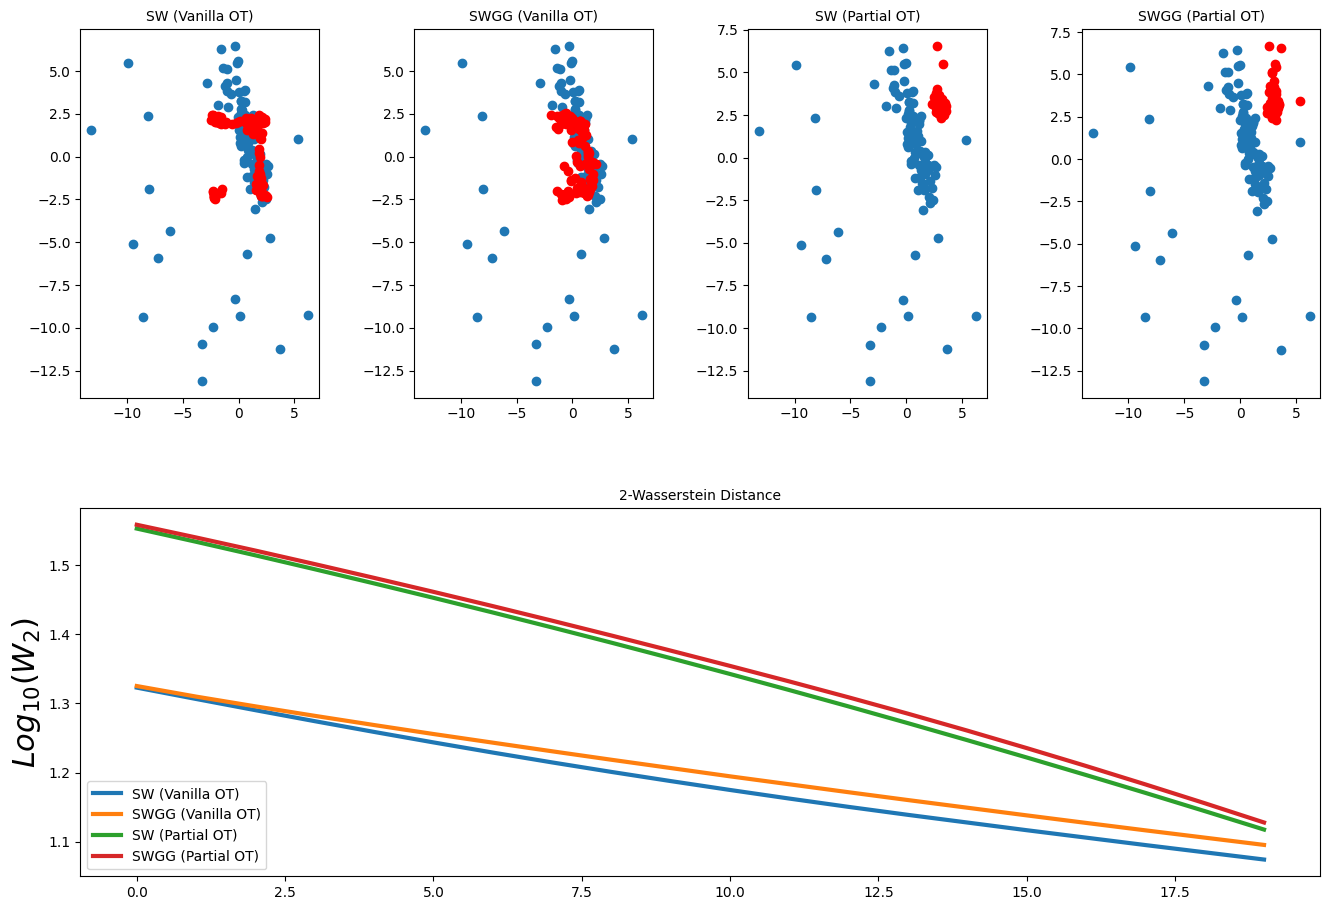

20 

KeyboardInterrupt: 

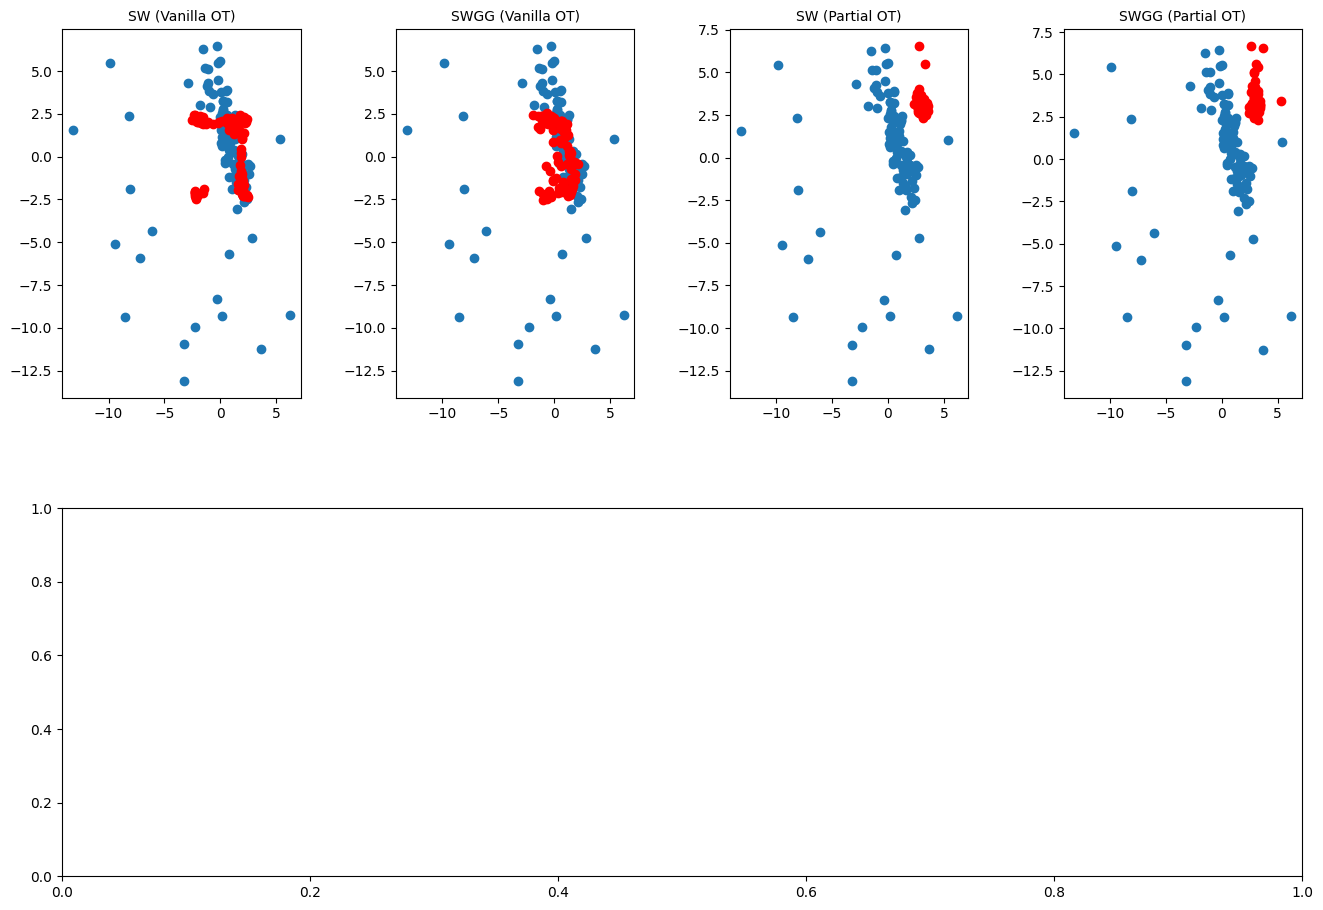

In [185]:
s = len(modes)

fig.clear()
fig = pl.figure(figsize=(4*s, 8+3))
grid = pl.GridSpec(2, s, wspace=.4, hspace=0.3)

plot_fig = True
mem_loss = []

#nofiterations = 5
for i in range(nofiterations):
    print(i,end=' ')
    loss = list()
    theta = torch.ones(len(modes),d)
    
    for k in range(s):
        # Loss computation
        #loss_ = 0
        if k == 0:
            l = gsw_res[k].sw(X.to(device), Y[k],theta=None)
        if k == 1:
            l, theta[k] = gsw_res[k].swgg(X.to(device), Y[k].to(device),theta=None)
        if k == 2:
            l = gsw_res[k].sw_partial(X.to(device), Y[k],theta=None) 
        if k==3:
            l, theta[k] = gsw_res[k].swgg_partial(X.to(device), Y[k],theta=None)
        
        # Optimization step
        loss_ = l
        loss.append(loss_)
        optimizer[k].zero_grad()
        loss[k].backward()
        optimizer[k].step()
        
        # Compute the 2-Wasserstein distance to compare the distributions
        if dist=='w2':
            w2_dist[i, k] = gradient_flows.w2(X.detach().cpu().numpy(), Y[k].detach().cpu().numpy())
            w2_dist_partial[i, k] = gradient_flows.w2(X.detach().cpu().numpy()[:80], Y[k].detach().cpu().numpy())
 
             
        theta2=theta.numpy()

        if plot_fig:
                temp = Y[k].detach().cpu().numpy()
                pl.subplot(grid[0, k])
                pl.cla()
                pl.scatter(X[:,0], X[:,1])
                pl.scatter(temp[:,0], temp[:,1],c='r')
                #pl.axline((0,0), theta2[k][0:2], color='C2')
                pl.title(titles[k], fontsize=10)
                xlim1,xlim2=pl.xlim()
                ylim1,ylim2=pl.ylim()
                pl.title(titles[k], fontsize=10)
    if plot_fig:
    # Plot the (partial) 2-Wasserstein distance
        pl.subplot(grid[1, 0:s])
        pl.cla()
        pl.plot(np.log10(w2_dist[:,:2]), linewidth=3)
        pl.plot(np.log10(w2_dist_partial[:,2:]), linewidth=3)
        pl.title('2-Wasserstein Distance', fontsize=10)
        pl.ylabel(r'$Log_{10}(W_2)$', fontsize=22)
        pl.legend(titles, fontsize=10, loc='lower left')
        
        
        display.clear_output(wait=True)
        display.display(pl.gcf()) 
        time.sleep(1e-5)    

        
    # Save the figure 
    
    fig.savefig(foldername + '/img%03d.png'%(i))
    for k in range(s):
        #pl.subplot(grid[:, k])
        pl.cla()
        
            
            

In [129]:
import imageio.v3 as iio
from glob import glob
from skimage.transform import resize

filenames = np.sort(glob(foldername + '/*.png'))

images = []
for filename in filenames:
    images.append(iio.imread(filename))
#iio.mimsave(dataset_name + '_comparison.gif', images)

iio.imwrite(dataset_name + '_comparison.gif', images, duration = 500, loop = 0)

In [131]:
iio.imwrite(dataset_name + '_comparison.gif', images, duration = 100, loop = 0)

In [97]:
filenames

array(['./Results/Gradient_Flow/Gifs/gaussian_2d_with_noise_Comparison/img000.png',
       './Results/Gradient_Flow/Gifs/gaussian_2d_with_noise_Comparison/img001.png',
       './Results/Gradient_Flow/Gifs/gaussian_2d_with_noise_Comparison/img002.png',
       './Results/Gradient_Flow/Gifs/gaussian_2d_with_noise_Comparison/img003.png',
       './Results/Gradient_Flow/Gifs/gaussian_2d_with_noise_Comparison/img004.png',
       './Results/Gradient_Flow/Gifs/gaussian_2d_with_noise_Comparison/img005.png',
       './Results/Gradient_Flow/Gifs/gaussian_2d_with_noise_Comparison/img006.png',
       './Results/Gradient_Flow/Gifs/gaussian_2d_with_noise_Comparison/img007.png',
       './Results/Gradient_Flow/Gifs/gaussian_2d_with_noise_Comparison/img008.png',
       './Results/Gradient_Flow/Gifs/gaussian_2d_with_noise_Comparison/img009.png',
       './Results/Gradient_Flow/Gifs/gaussian_2d_with_noise_Comparison/img010.png',
       './Results/Gradient_Flow/Gifs/gaussian_2d_with_noise_Comparison/img01

In [39]:
loss


[tensor(9814.5664, grad_fn=<AddBackward0>),
 tensor(55.7619, grad_fn=<AddBackward0>),
 tensor(1.7782, grad_fn=<AddBackward0>),
 tensor(9.0337, grad_fn=<AddBackward0>),
 tensor(32.7467, dtype=torch.float64, grad_fn=<AddBackward0>)]

In [35]:
theta[k]

tensor([-0.9980,  0.0631])